## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_core.interface.atomic import *

from oqd_trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 200,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=downstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

Yb171_2 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, -1],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(
    energy=2 * np.pi * 0.1, eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0]
)

system = System(
    ions=[Yb171, Yb171_2],
    modes=[COM_x],
)

Omega = 2 * np.pi * 5
Delta = 2 * np.pi * 25
mu = 2 * np.pi * 0.11


beam = Beam(
    transition=transitions[0],
    rabi=2 * Omega,
    detuning=Delta,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta + mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam3 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta - mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam4 = Beam(
    transition=transitions[0],
    rabi=2 * Omega,
    detuning=Delta,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[-1, 0, 0],
    target=1,
)

beam5 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta + mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)

beam6 = Beam(
    transition=transitions[2],
    rabi=Omega,
    detuning=Delta - mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)

protocol = SequentialProtocol(
    sequence=[
        ParallelProtocol(
            sequence=[
                Pulse(beam=beam, duration=5),
                Pulse(beam=beam2, duration=5),
                Pulse(beam=beam3, duration=5),
                Pulse(beam=beam4, duration=5),
                Pulse(beam=beam5, duration=5),
                Pulse(beam=beam6, duration=5),
            ]
        ),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("8_example_molmer_sorenson.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("8_example_molmer_sorenson.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend(solver_options=dict(progress_bar=True))

fock_cutoff = 4
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [7]:
from oqd_compiler_infrastructure import Post

from oqd_trical.light_matter.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(backend.intermediate))

AtomicEmulatorCircuit
  - frame: NoneType(None)
  - base: Operator(62.83185307179586 * |1><1|_E0 @ I_E1 @ I_P0 + 628.3185307179587 * |2><2|_E0 @ I_E1 @ I_P0 + 1256.6370614359173 * |3><3|_E0 @ I_E1 @ I_P0 + 62.83185307179586 * I_E0 @ |1><1|_E1 @ I_P0 + 628.3185307179587 * I_E0 @ |2><2|_E1 @ I_P0 + 1256.6370614359173 * I_E0 @ |3><3|_E1 @ I_P0 + 0.6283185307179586 * I_E0 @ I_E1 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(31.415926535897928 * exp(1j * (-785.3981633974483 * t)) * |0><2|_E0 @ I_E1 @ D(-37.88540168956306 * exp(1j * (1.5707963267948966)))_P0 + 31.415926535897928 * exp(1j * (-785.3981633974483 * t)) * |2><0|_E0 @ I_E1 @ D(-37.88540168956306 * exp(1j * (1.5707963267948966)))_P0 + 31.415926535897928 * exp(1j * (785.3981633974483 * t)) * |0><2|_E0 @ I_E1 @ D(-37.88540168956306 * exp(1j * (-1.5707963267948966)))_P0 + 31.415926535897928 * exp(1j * (785.3981633974483 * t)) * |2><0|_E0 @ I_E1 @ D(-37.88540168956306 * exp(1j * (-1.5707963

### Results


In [8]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.0%. Run time: 260.48s. Est. time left: 00:00:38:59


20.0%. Run time: 514.30s. Est. time left: 00:00:34:12


30.1%. Run time: 780.01s. Est. time left: 00:00:30:14


40.1%. Run time: 1035.05s. Est. time left: 00:00:25:47


50.1%. Run time: 1289.73s. Est. time left: 00:00:21:24


60.1%. Run time: 1546.36s. Est. time left: 00:00:17:05


70.1%. Run time: 1805.84s. Est. time left: 00:00:12:48


80.2%. Run time: 2064.80s. Est. time left: 00:00:08:31


90.2%. Run time: 2321.00s. Est. time left: 00:00:04:12


100.0%. Run time: 2568.84s. Est. time left: 00:00:00:00


Total run time: 2568.84s


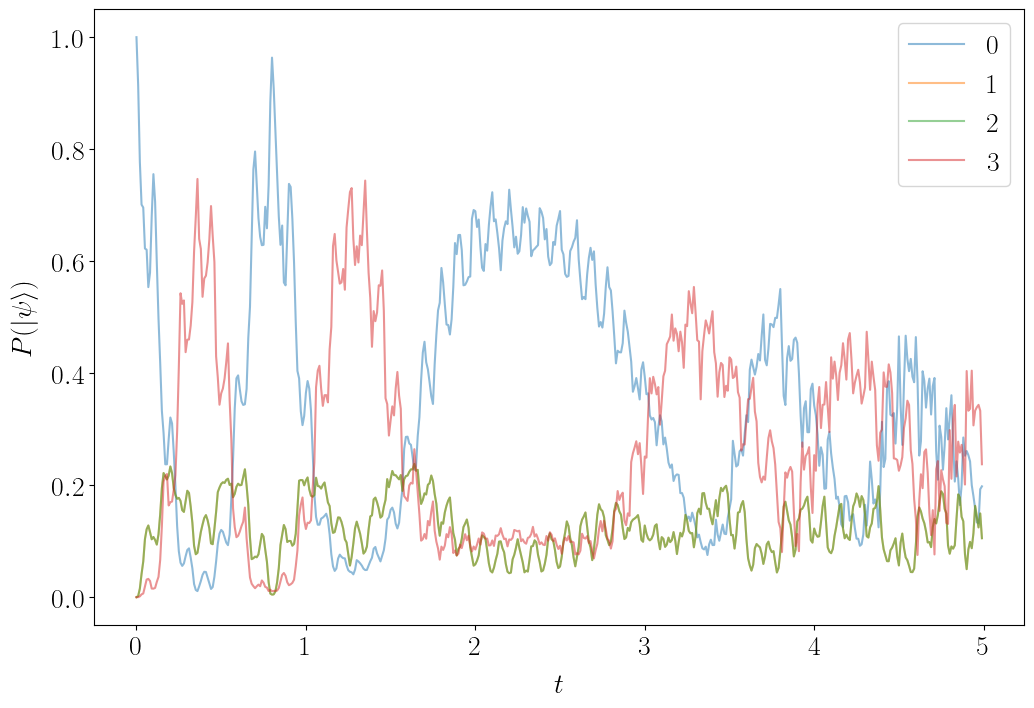

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

state_labels = [0, 1, 4, 5]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(
    result["tspan"][k],
    plot_states,
    label=range(len(state_labels)),
    alpha=0.5,
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

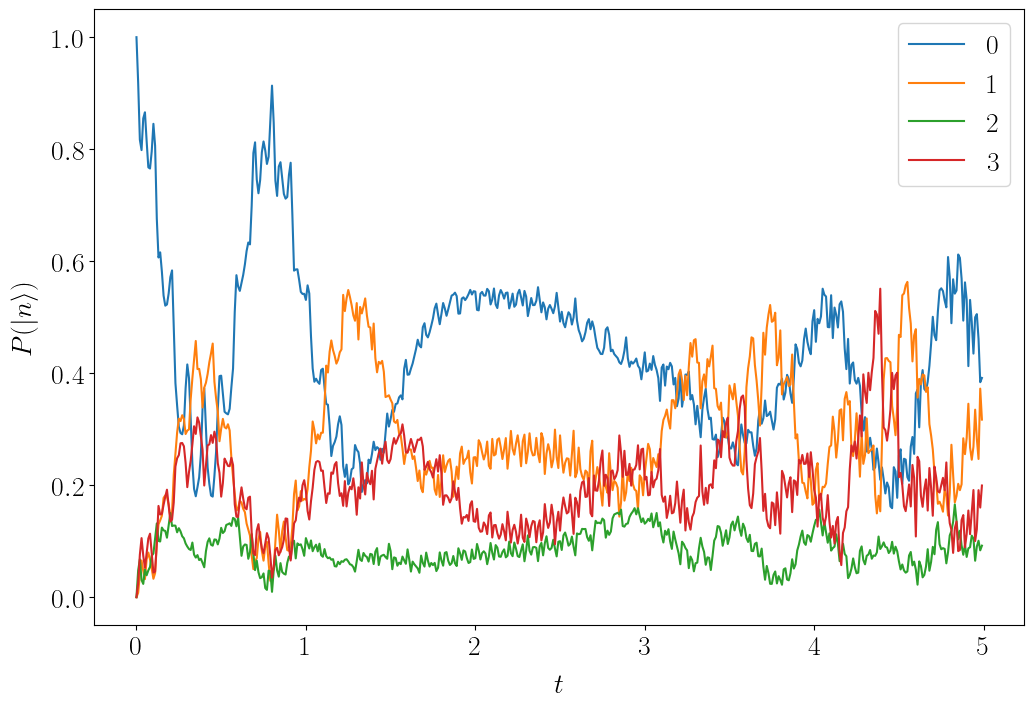

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag() for s in result["states"][k]],
    label=range(fock_cutoff),
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax.legend()